# Curve Building with AAD

---

## Intro

We implement a simple/stylised interest-rate curve builder in the single curve setting.

The curve builder has the following features/simplifications:
- The curve is calibrated exclusively to par swap rates, with the number of curve grid points (discount factors) chosen to match exactly the number of market instruments, yielding a square, well-posed calibration problem.
- The bootstrap is formulated as a nonlinear root-finding problem in the discount factors, solved using a Newton–Raphson algorithm.
- Automatic Adjoint Differentiation (AAD) is used to compute the Jacobian of swap rates with respect to the zero rates.
- The Jacobians are reused both within the Newton iterations and for fast first-order re-calibration of the curve in response to small market moves.

## What is Curve Building?

We consider the problem of constructing an interest rate (IR) curve by calibrating a set of discount factors to observed market swap rates. 

Formally, an IR curve $C : [0,\infty) \mapsto (0,\infty)$ at time zero (in discount factor representation) is the map
$$
C : T \mapsto P(0,T),
$$
where $T$ is the tenor of the IR curve, and $P(0,T)$ is the credit risk-free zero coupon bond price (discount factor) maturing at time $T$. Practically, an IR curve is a set of discount factors $P(0,T_i)$ (curve pillars), along with an interpolation scheme. 

Suppose our IR curve has $N$ pillars,
$$
\mathbf{D} = (P(0,T_1), \dots, P(0,T_N)),
$$
and we want to calibrate our curve to $M$ market quotes:
$$
\mathbf{S}^{\text{mkt}} = (S_1^{\text{mkt}}, \dots, S_M^{\text{mkt}}).
$$ 

Each model-implied rate defines a nonlinear mapping $\mathbf{D} \mapsto S_i(\mathbf{D})$. The curve construction problem is then to find $\mathbf{D}$ such that
$$
S_i(\mathbf{D}) \approx S_i^{\text{mkt}}, \qquad\text{for } i = 1,\dots,M.
$$
Note that in general $M \neq N$:
- **Square case ($M = N$):** an exact solution exists and all market instruments can be priced exactly.
- **Overdetermined case ($M > N$):** there are more market quotes than degrees of freedom, so no exact solution exists; calibration must be done approximately (e.g., least-squares).
- **Underdetermined case ($M < N$):** there are more degrees of freedom than market quotes, leading to infinitely many solutions; additional constraints or regularisation are required to select a unique curve.

## Stylised Case: Curve Construction as Root Finding

For simplicity:
- we calibrate our entire curve purely to swap quotes,
- we assume single curve setting (typical for RFR swaps),
- we assume the swap tenors match exactly with our curve pillars, and
- we choose the number of pillars to match exactly with the number of market quotes.

Practically, this means:
- we only need to define a single type of functions $S_i(\mathbf{D})$ that corresponds to the PVs of the standard RFR swaps
- we have a simple square problem to solve, meaning we will be able to find a solution that reprices all market instruments exactly, 

$$
S_i(\mathbf{D}) = S_i^{\text{mkt}}, \qquad \text{for } i = 1,\dots,N.
$$

If we define the residual function
$$
\mathbf{f}(\mathbf{D}) = \mathbf{S}(\mathbf{D}) - \mathbf{S}^{\text{mkt}},
$$
then the curve building problem reduces to a root finding problem - finding a root $\mathbf{D}^\ast$ such that the residual function is zero, $\mathbf{f}(\mathbf{D}^\ast) = \mathbf{0}$.

## Newton–Raphson with Automatic Adjoint Differentiation (AAD)

To solve the nonlinear root-finding problem
$$
\mathbf{f}(\mathbf{D}) = \mathbf{0},
$$
we employ the classic Newton–Raphson (NR) method. Starting from an initial guess $\mathbf{D}^{(0)}$, the NR iteration is defined by
$$
\mathbf{D}^{(k+1)} = \mathbf{D}^{(k)} - \mathbf{J}(\mathbf{D}^{(k)})^{-1} \, \mathbf{f}(\mathbf{D}^{(k)}),
$$
where $\mathbf{J}(\mathbf{D}) \in \mathbb{R}^{N \times N}$ is the Jacobian matrix of first-order partial derivatives,
$$
\mathbf{J}_{ij}(\mathbf{D}) = \frac{\partial S_i(\mathbf{D})}{\partial D_j}.
$$

In the context of curve construction, the Jacobian captures the sensitivities of each model-implied swap price wrt each curve pillar (discount factor). These sensitivities are required at every NR iteration and are central to both calibration efficiency and numerical stability.

### Why Newton Raphson?

An important by-product of this approach is that the calibrated Jacobian provides a first-order linear approximation of the mapping $\mathbf{D} \mapsto \mathbf{S}(\mathbf{D})$ around the calibrated solution $\mathbf{D}^\ast$. 

The Jacobian is extremely useful in the risk management of any rates product for two reasons:
- For small market moves $\Delta \mathbf{S}^{\text{mkt}}$, the corresponding change in the curve can be approximated by
$$
\Delta \mathbf{D} \approx \mathbf{J}(\mathbf{D}^\ast)^{-1} \, \Delta \mathbf{S}^{\text{mkt}},
$$
allowing for fast first-order curve re-calibration without re-running the full nonlinear solver.
- Production risk engine can simply compute sensitivities of derivative prices wrt discount factors (i.e. zero risks: $\partial V/\partial \mathbf{D} \in \mathbb{R}^N$) without worrying exactly what calibration instruments were used, then apply the Jacobian to convert the zero risks to sensitivities wrt market quotes instead (i.e. market risks: $\partial V/\partial \mathbf{S} \in \mathbb{R}^N$):

$$
\frac{\partial V}{\partial \mathbf{S}}
\approx
\frac{\partial V}{\partial \mathbf{D}} \, 
\mathbf{J}^{-1}.
$$

### Why AAD?

Rather than computing the Jacobian via finite differencing (FD), we compute it **exactly** using Automatic Adjoint Differentiation (AAD). Mathematically, AAD views a function  
$$
y = f(x_1,\dots,x_n)
$$
as a composition of elementary operations
$$
v_1 = f_1(x), \quad v_2 = f_2(v_1), \ \dots,\ v_K = f_K(v_{K-1}), \quad y = v_K,
$$
where each elementary operation has well defined derivatives. Defining adjoint variables $\bar v_i := \partial y / \partial v_i$ with terminal condition $\bar v_K \equiv \partial y / \partial y = 1$, AAD computes all input sensitivities by a single reverse sweep using the chain rule,
$$
\bar v_i = \sum_{j:\, v_i \to v_j} \bar v_j \frac{\partial v_j}{\partial v_i}, \qquad 
\frac{\partial y}{\partial x_\ell} = \sum_{i} \bar v_i \frac{\partial v_i}{\partial x_\ell}.
$$

This computes the exact gradient at a cost proportional to the original function evaluation, independent of the input dimension.

We can see that AAD has two major advantages over the traditional FD method:
- AAD produces exact derivatives (numerically stable)
- AAD is time efficient

In summary, combining NR with AAD yields a stable and computationally efficient calibration framework that naturally produces exact Jacobian. The Jacobian can then be used for:
- fast first order recalibration of IR curves, and
- market risks sensitivity estimation.

NR with AAD is a standard method within the industry to build IR curves when dealing with a square problem.

## Minimal AAD Curve Builder Implementation

One major drawback of AAD is that it requires significant refactoring of an existence codebase. In the following, we will illustrate why. 

In [1]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Callable, List

import math
import numpy as np

from abc import ABC, abstractmethod
from typing import Dict

from dataclasses import dataclass
from typing import Dict

### Scalar and Tape with Primative Operations

In [2]:
@dataclass
class AADScalar:
    value: float
    idx: int


class Tape:
    def __init__(self) -> None:
        self.values: List[float] = []
        self.adjoints: List[float] = []
        self.backward_ops: List[Callable[[], None]] = []

    def var(self, value: float) -> AADScalar:
        idx = len(self.values)
        self.values.append(value)
        self.adjoints.append(0.0)
        return AADScalar(value, idx)

    def op(self, value: float, backward: Callable[[], None]) -> AADScalar:
        idx = len(self.values)
        self.values.append(value)
        self.adjoints.append(0.0)
        self.backward_ops.append(backward)
        return AADScalar(value, idx)

    def backward(self, seed: AADScalar) -> None:
        self.adjoints[seed.idx] = 1.0
        for op in reversed(self.backward_ops):
            op()


def add(t: Tape, x: AADScalar, y: AADScalar) -> AADScalar:
    out = t.op(x.value + y.value, lambda: None)

    def backward():
        t.adjoints[x.idx] += t.adjoints[out.idx]
        t.adjoints[y.idx] += t.adjoints[out.idx]

    t.backward_ops[-1] = backward
    return out

def mul(t: Tape, x: AADScalar, y: AADScalar) -> AADScalar:
    out = t.op(x.value * y.value, lambda: None)

    def backward():
        t.adjoints[x.idx] += t.adjoints[out.idx] * y.value
        t.adjoints[y.idx] += t.adjoints[out.idx] * x.value

    t.backward_ops[-1] = backward
    return out

def log(tape: Tape, x: AADScalar) -> AADScalar:
    out = tape.op(math.log(x.value), lambda: None)

    def backward():
        tape.adjoints[x.idx] += tape.adjoints[out.idx] / x.value

    tape.backward_ops[-1] = backward
    return out

def exp(tape: Tape, x: AADScalar) -> AADScalar:
    out = tape.op(math.exp(x.value), lambda: None)

    def backward():
        tape.adjoints[x.idx] += tape.adjoints[out.idx] * out.value

    tape.backward_ops[-1] = backward
    return out


### Interpolation strategy

In [3]:
from abc import ABC, abstractmethod
from typing import Dict, Tuple, List
import math

class Interpolator(ABC):
    @abstractmethod
    def df(self, t: float, node_dfs: Dict[float, "AADScalar"], tape: "Tape") -> "AADScalar":
        ...

    # --- shared helper ---
    @staticmethod
    def find_interval(t: float, sorted_pillars: List[float]) -> Tuple[int, int, float]:
        """
        Find the interval [i, j] that contains t, and the weight w for interpolation.
        Returns (i, j, w) with t_i <= t <= t_j, w = (t - t_i) / (t_j - t_i)
        """
        if t < sorted_pillars[0] or t > sorted_pillars[-1]:
            raise ValueError("Time outside curve")
        for i in range(len(sorted_pillars) - 1):
            t_i, t_j = sorted_pillars[i], sorted_pillars[i + 1]
            if t_i <= t <= t_j:
                w = (t - t_i) / (t_j - t_i) if t_j != t_i else 0.0
                return i, i + 1, w
        # if t == last pillar
        return len(sorted_pillars) - 2, len(sorted_pillars) - 1, 1.0


class LinearDFInterpolator(Interpolator):
    def df(self, t: float, node_dfs: Dict[float, "AADScalar"], tape: "Tape") -> "AADScalar":
        sorted_pillars = sorted(node_dfs.keys())
        sorted_dfs = [node_dfs[p] for p in sorted_pillars]
        i, j, w = self.find_interval(t, sorted_pillars)

        w_ = tape.var(w)
        one = tape.var(1.0)
        return add(
            tape,
            mul(tape, sorted_dfs[i], add(tape, one, mul(tape, tape.var(-1.0), w_))),
            mul(tape, sorted_dfs[j], w_)
        )


class LogLinearDFInterpolator(Interpolator):
    def df(self, t: float, node_dfs: Dict[float, "AADScalar"], tape: "Tape") -> "AADScalar":
        sorted_pillars = sorted(node_dfs.keys())
        sorted_dfs = [node_dfs[p] for p in sorted_pillars]
        i, j, w = self.find_interval(t, sorted_pillars)

        w_ = tape.var(w)
        one = tape.var(1.0)
        log_df_i = log(tape, sorted_dfs[i])
        log_df_j = log(tape, sorted_dfs[j])
        interp_log = add(
            tape,
            mul(tape, log_df_i, add(tape, one, mul(tape, tape.var(-1.0), w_))),
            mul(tape, log_df_j, w_)
        )
        return exp(tape, interp_log)


class PiecewiseConstantDFInterpolator(Interpolator):
    def df(self, t: float, node_dfs: Dict[float, "AADScalar"], tape: "Tape") -> "AADScalar":
        sorted_pillars = sorted(node_dfs.keys())
        sorted_dfs = [node_dfs[p] for p in sorted_pillars]

        if t < sorted_pillars[0] or t > sorted_pillars[-1]:
            raise ValueError("Time outside curve")

        for i in range(len(sorted_pillars) - 1):
            if sorted_pillars[i] <= t < sorted_pillars[i + 1]:
                return sorted_dfs[i]
        return sorted_dfs[-1]  # t == last pillar


class LinearZeroRateInterpolator(Interpolator):
    """
    AAD-compatible linear interpolation in zero rates.
    """
    def df(self, t: float, node_dfs: Dict[float, "AADScalar"], tape: "Tape") -> "AADScalar":
        sorted_pillars = sorted(node_dfs.keys())
        sorted_dfs = [node_dfs[p] for p in sorted_pillars]

        # Compute zero rates at pillars
        zero_rates = []
        for t_i, D_i in zip(sorted_pillars, sorted_dfs):
            if t_i == 0.0:
                zero_rates.append(tape.var(0.0))
            else:
                zero_rates.append(mul(tape, tape.var(-1.0 / t_i), log(tape, D_i)))

        i, j, w = self.find_interval(t, sorted_pillars)
        w_ = tape.var(w)
        one = tape.var(1.0)

        R_t = add(
            tape,
            mul(tape, zero_rates[i], add(tape, one, mul(tape, tape.var(-1.0), w_))),
            mul(tape, zero_rates[j], w_)
        )

        return exp(tape, mul(tape, tape.var(-t), R_t))

class PiecewiseConstantZeroRateInterpolator(Interpolator):
    """
    AAD-compatible piecewise constant interpolation in zero rate space.
    For t in [T_i, T_{i+1}), zero rate R_i is constant, so
    D(t) = exp(-t * R_i)
    """
    def df(self, t: float, node_dfs: Dict[float, "AADScalar"], tape: "Tape") -> "AADScalar":
        sorted_pillars = sorted(node_dfs.keys())
        sorted_dfs = [node_dfs[p] for p in sorted_pillars]

        # Compute zero rates at pillars
        zero_rates = []
        for t_i, D_i in zip(sorted_pillars, sorted_dfs):
            if t_i == 0.0:
                zero_rates.append(tape.var(0.0))
            else:
                zero_rates.append(mul(tape, tape.var(-1.0 / t_i), log(tape, D_i)))

        # Find the interval
        i, j, _ = self.find_interval(t, sorted_pillars)

        # Use zero rate at left pillar (i) as constant
        R_i = zero_rates[i]

        return exp(tape, mul(tape, tape.var(-t), R_i))



### Interest Rate Curve

In [4]:
@dataclass
class Curve:
    node_dfs: Dict[float, AADScalar]  # key: pillar, value: df
    interpolator: Interpolator
    tape: Tape

    def df(self, t: float) -> AADScalar:
        return self.interpolator.df(t, self.node_dfs, self.tape)


@dataclass
class FloatCurve:
    """A fully float-based curve for plotting or non-AAD calculations."""
    node_dfs: Dict[float, float]  # pillar -> DF
    interpolator: Interpolator

    def df(self, t: float) -> float:
        """Return interpolated DF at t as a float."""
        # We wrap a tiny adapter interpolator that works with floats
        class FloatInterpolator(Interpolator):
            def df(self, t_: float, node_dfs: Dict[float, float], tape=None) -> float:
                sorted_pillars = sorted(node_dfs.keys())
                sorted_dfs = [node_dfs[p] for p in sorted_pillars]
                for i in range(len(sorted_pillars) - 1):
                    if sorted_pillars[i] <= t_ <= sorted_pillars[i + 1]:
                        w = (t_ - sorted_pillars[i]) / (sorted_pillars[i + 1] - sorted_pillars[i])
                        return sorted_dfs[i] * (1 - w) + sorted_dfs[i + 1] * w
                raise ValueError("Time outside curve")
        float_interp = FloatInterpolator()
        return float_interp.df(t, self.node_dfs)

### Swap Pricing


Let's define explicitly the functions $\mathbf{S}(\mathbf{D})$ to compute the model implied RFR swap PVs.

Ignoring the boring details such as:
- spot settlement date
- day count fraction
- fixing/payment schedule
- calendar
- etc...

The PV of a standard (used for market quoting) spot-starting payer RFR swap with tenor $T$ is 
$$
V(0,T) = 1-P(0,T) - S(0,T)A(0,T),
$$
where $\tau(T_{i-1}, T_i) =  T_i - T_{i-1}$ is the accural fraction and $A(0,T) := \sum_{i: 0 \leq t_i \leq T} \tau(T_{i-1}, T_i) P(0,T_i)$ is the swap annuity.

In [5]:
from typing import List

def swap_pv(
    curve: Curve, # we implicitly assumed single curve
    swap_tenor: int,
    fixed_rate: float,
    fixed_leg_frequency: float = 0.5
) -> AADScalar:
    """
    Plain-vanilla fixed-for-float spot-starting swap PV (payer fixed).

    Parameters
    ----------
    curve : Curve
        Discount curve (AAD-enabled)
    swap_tenor : int
        Length of the swap in years (e.g. 1.0, 2.0, 5.0)
    fixed_rate : float
        Fixed rate (annualized)
    fixed_leg_frequency : float
        Fixed leg payment interval (e.g. 1.0, 0.5, 0.25)

    Returns
    -------
    AADScalar
        Swap PV
    """
    tape = curve.tape
    pv = tape.var(0.0)

    # Build fixed leg payment schedule (spot-starting)
    payment_times: List[float] = []
    t = fixed_leg_frequency
    while t <= swap_tenor + 1e-12:
        payment_times.append(t)
        t += fixed_leg_frequency

    accrual = tape.var(fixed_leg_frequency)

    prev_t = 0.0

    for t in payment_times:
        df = curve.df(t)

        # Fixed leg: K * accrual * DF(t)
        fixed_cf = mul(
            tape,
            tape.var(fixed_rate),
            mul(tape, accrual, df)
        )

        # Floating leg: DF(prev) - DF(curr)
        if prev_t == 0.0:
            df_prev = tape.var(1.0)
        else:
            df_prev = curve.df(prev_t)

        float_cf = add(
            tape,
            df_prev,
            mul(tape, tape.var(-1.0), df)
        )

        # Payer fixed: receive float, pay fixed
        pv = add(
            tape,
            pv,
            add(tape,
                float_cf,
                mul(tape, tape.var(-1.0), fixed_cf)
               )
        )

        prev_t = t

    return pv


### Curve Builder and Newton Raphson Solver

In [6]:
@dataclass
class CurveBuilder:
    """
    Build a discount curve using a set of spot-starting swaps.
    Solver is injected (e.g., Newton-Raphson).
    """
    maturities: List[float]               # swap tenors (spot starting)
    swap_rates: List[float]               # market swap rates
    interpolator: Interpolator
    tape_factory: Callable[[], Tape]      # function to create a new tape
    jacobian: np.ndarray | None = None  # store calibrated Jacobian
    max_iter: int = 10
    tol: float = 1e-10

    def build(self, solver: Callable) -> "FloatCurve":
        """
        Calibrate the curve using the provided solver and return a Curve.

        Parameters
        ----------
        solver : Callable
            Function that takes maturities, swap_rates, interpolator, tape_factory, max_iter, tol
            and returns calibrated node DFs as Dict[float, AADScalar]

        Returns
        -------
        curve : FloatCurve
            Calibrated interest rate curve with interpolation
        """
        # Solver returns node DFs
        curve, self.jacobian = solver(
            self.maturities,
            self.swap_rates,
            self.interpolator,
            self.tape_factory,
            self.max_iter,
            self.tol
        )
        return curve

    def get_jacobian(self) -> np.ndarray | None:
        return self.jacobian


def newton_raphson_solver(
    maturities: List[float],
    swap_rates: List[float],
    interpolator: Interpolator,
    tape_factory: Callable[[], Tape],
    max_iter: int = 10,
    tol: float = 1e-10
) -> tuple[FloatCurve, np.ndarray]:

    n = len(maturities)
    D_vals = np.exp(-0.0 * np.array(maturities))

    for _ in range(max_iter):
        F = np.zeros(n)
        J = np.zeros((n, n))

        for i in range(n):
            tape = tape_factory()
            dfs = [tape.var(D_vals[j]) for j in range(n)]
            node_dfs = {0.0: tape.var(1.0)}
            node_dfs.update({maturities[j]: dfs[j] for j in range(n)})

            curve = Curve(node_dfs=node_dfs, interpolator=interpolator, tape=tape)
            pv = swap_pv(curve, maturities[i], swap_rates[i], fixed_leg_frequency=1.0)
            tape.backward(pv)

            F[i] = pv.value
            for j in range(n):
                J[i, j] = tape.adjoints[dfs[j].idx]

        delta = np.linalg.solve(J, F)
        D_vals -= delta
        last_jacobian = J.copy()
        if np.linalg.norm(delta) < tol:
            break

    # Return a float-based curve
    float_node_dfs = {0.0: 1.0, **{maturities[i]: float(D_vals[i]) for i in range(n)}}
    float_curve = FloatCurve(node_dfs=float_node_dfs, interpolator=interpolator)

    return float_curve, last_jacobian


Based on the minimal implementation above, we can see that AAD is not simply an extra layer that can be plugged into existing pricing library. 

In order to compute exact adjoints, each numeric operation in the codebase — from PV calculations, interpolation, to arithmetic — must be wrapped in tape-aware functions producing AADScalars. This usually requires rewriting or refactoring existing float-based code to integrate with the tape mechanism. Hence, it is not trivial to make large (legacy) enterprice level pricing library to be AAD compatible.

### Dummy Example: How do the calibrated curves and Jacobians look like?

In [7]:
# Naive setup
maturities = [1, 2, 3, 10]   
swap_rates = [0.05] * 4     

In [8]:
interpolators = {
    "loglinear": LogLinearDFInterpolator(),
    "linear": LinearDFInterpolator(),
    "piecewise_constant": PiecewiseConstantDFInterpolator(),
    "linear_zero_rate": LinearZeroRateInterpolator(),
    "piecewise_constant_zero_rate": PiecewiseConstantZeroRateInterpolator()
}

# Separate dictionaries for curves and jacobians
curves: Dict[str, "FloatCurve"] = {}
jacobians: Dict[str, np.ndarray] = {}

for name, interpolator in interpolators.items():
    try:
        builder = CurveBuilder(
            maturities=maturities,
            swap_rates=swap_rates,
            interpolator=interpolator,
            tape_factory=Tape
        )
        curve = builder.build(newton_raphson_solver)
        
        # Store results separately
        curves[name] = curve
        jacobians[name] = builder.jacobian
        
        print(f"Successfully calibrated curve using {name} interpolation.")
    
    except Exception as e:
        print(f"ERROR: Failed to calibrate curve using {name} interpolation. Error message: {e}")

Successfully calibrated curve using loglinear interpolation.
Successfully calibrated curve using linear interpolation.
Successfully calibrated curve using piecewise_constant interpolation.
Successfully calibrated curve using linear_zero_rate interpolation.
ERROR: Failed to calibrate curve using piecewise_constant_zero_rate interpolation. Error message: Singular matrix


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List

def plot_curve(curves: Dict[str, "FloatCurve"], num_points: int = 200):
    """
    Plot one or multiple discount curves and corresponding zero rates.
    
    Parameters
    ----------
    curves : Dict[str, FloatCurve]
        Dictionary of curves to plot. Key is the label for the legend.
        FloatCurve should have:
            - node_dfs: Dict[float, float], mapping pillar tenor -> DF
            - df(t: float) -> float, interpolation method
    num_points : int
        Number of points to interpolate between the min and max pillar.
    """
    
    # Create two subplots: top DF, bottom zero rates
    fig, axes = plt.subplots(2, 1, figsize=(10,8), gridspec_kw={'height_ratios': [3,2]}, sharex=True)
    
    colors = plt.cm.tab10.colors  # 10 distinct colors
    
    for i, (label, curve) in enumerate(curves.items()):
        color = colors[i % len(colors)]
        
        pillars = sorted(curve.node_dfs.keys())
        df_pillars = [curve.node_dfs[t] for t in pillars]
        
        # Interpolated points
        t_vals = np.linspace(min(pillars), max(pillars), num_points)
        df_vals = [curve.df(t) for t in t_vals]
        zero_vals = [-np.log(curve.df(t)) / t if t > 0 else None for t in t_vals]  # continuously compounded
        
        # Top: Discount Factor
        axes[0].plot(t_vals, df_vals, linestyle='--', color=color)
        axes[0].plot(pillars, df_pillars, 'o', color=color, label=label)
        
        # Bottom: Zero Rates
        axes[1].plot(t_vals, zero_vals, linestyle='--', color=color)
        zero_pillars = [-np.log(df)/t if t > 0 else 0.0 for t, df in zip(pillars, df_pillars)]
        axes[1].plot(pillars, zero_pillars, 'o', color=color)
    
    # Top plot styling
    axes[0].set_ylabel("Discount Factor (DF)")
    axes[0].set_title("Discount Curves")
    axes[0].grid(color='lightgrey', linestyle='-', linewidth=0.5)
    axes[0].legend()
    
    # Bottom plot styling
    axes[1].set_xlabel("Tenor (years)")
    axes[1].set_ylabel("Zero Rate (continuous)")
    axes[1].set_title("Zero Rate Curves")
    axes[1].grid(color='lightgrey', linestyle='-', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

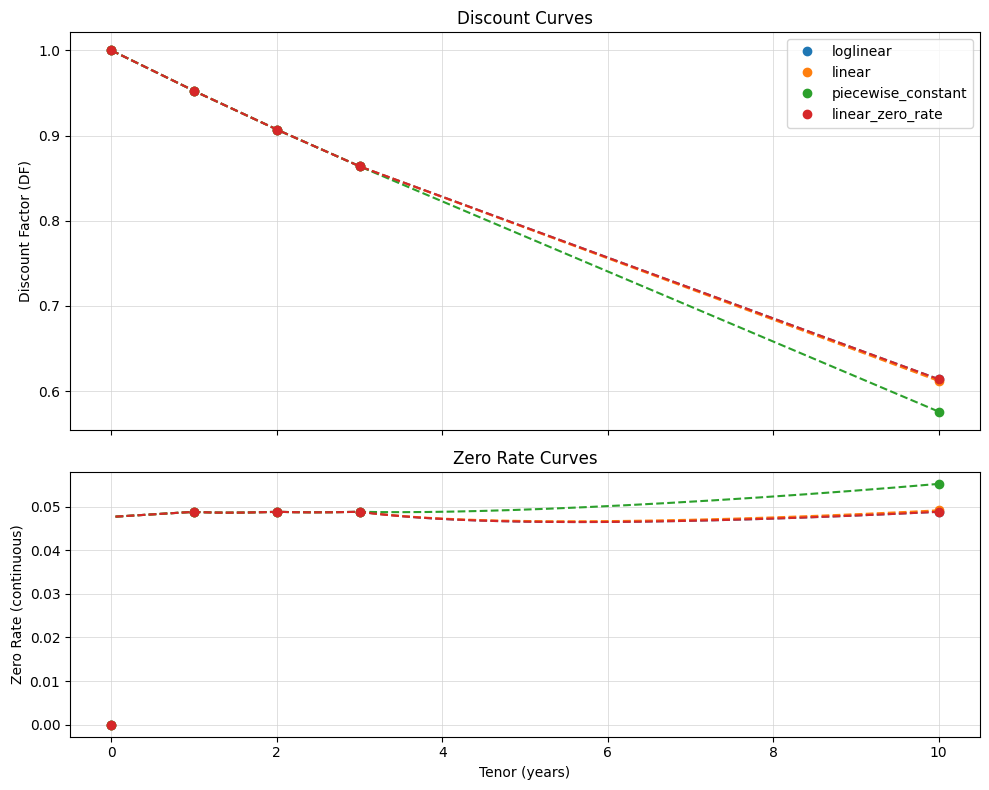

In [10]:
plot_curve(curves)

### Why calibrated DFs at pillar points are different?

The key reason why the calibrated DFs at pillar points are different, is that the PV of each cashflow is dependent on the interpolation scheme. 

In our case, the fixed leg has a semi-annual schedule. However, we only have market quotes at {1,2,3,4,10} years. This means a significant number of discount factors required to compute the annuities (especially for the 10 year swap) are determined by interpolation. As such, to fully reprice the swap.


In [11]:
def plot_jacobian(jacobian: np.ndarray, maturities: list[float], 
                  title = "Jacobian Heatmap", cmap: str = "cividis"):
    """
    Plot the Jacobian of swap PVs w.r.t. discount factors as a single-color heatmap,
    numerical values overlaid, grid aligned to cells, y-axis decreasing swap tenor.
    """
    n = len(maturities)
    plt.figure(figsize=(8,6))
    
    # Display heatmap (as-is)
    im = plt.imshow(jacobian, origin='upper', cmap=cmap, interpolation='nearest', aspect='equal')
    
    # Colorbar
    cbar = plt.colorbar(im)
    cbar.set_label("dPV / dDF")
    
    # Tick labels
    plt.xticks(ticks=np.arange(n), labels=[f"{t:.1f}" for t in maturities])
    plt.yticks(ticks=np.arange(n), labels=[f"{t:.1f}" for t in maturities])
    
    plt.xlabel("Discount Factor Pillars (DF_j)")
    plt.ylabel("Swap PV Tenors (PV_i)")
    plt.title(title)
    
    # Overlay numerical values (to 2 significant figures)
    for i in range(n):
        for j in range(n):
            val = jacobian[i, j]
            plt.text(
                j, i, f"{val:.2g}",
                ha='center', va='center',
                color='white' if val > jacobian.max()/2 else 'black',
                fontsize=9
            )
    
    # Cell-aligned grid lines
    ax = plt.gca()
    ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
    ax.grid(which='minor', color='lightgrey', linestyle='-', linewidth=1)
    ax.grid(False)
    
    plt.show()

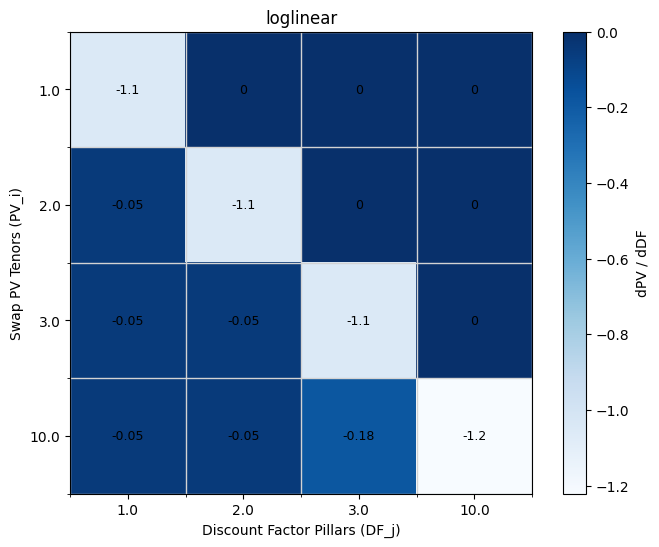

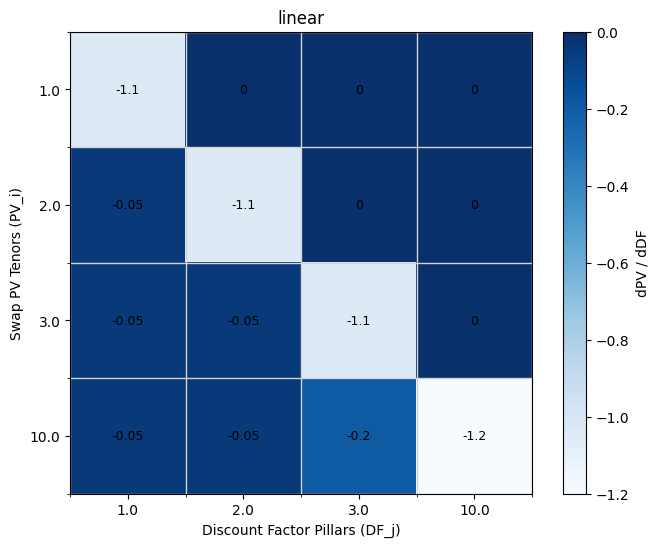

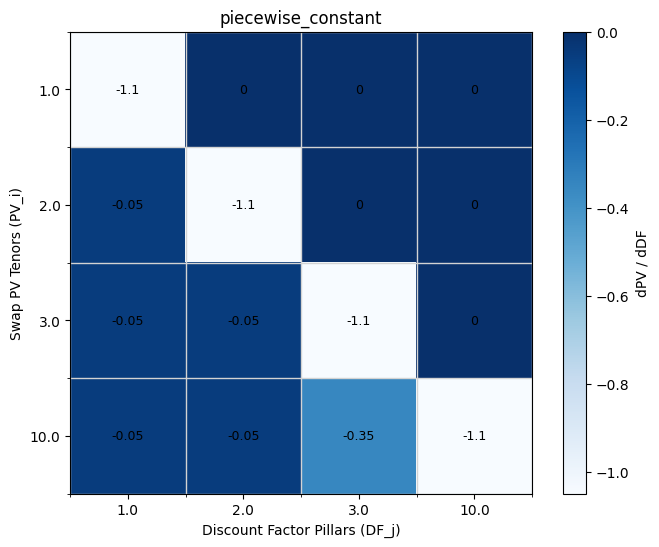

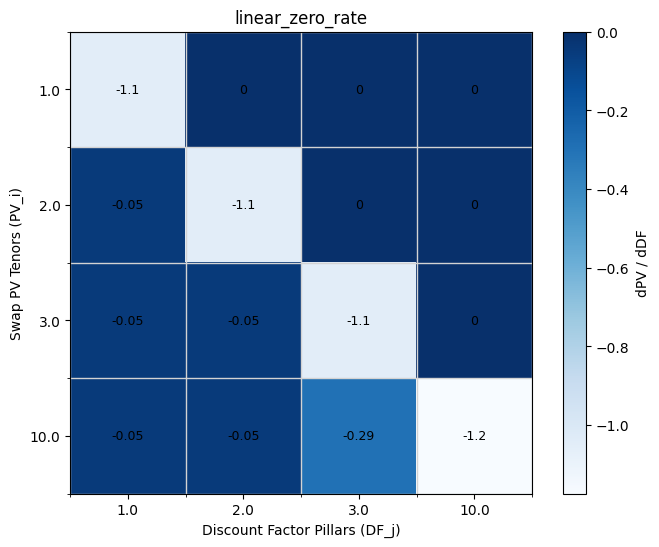

In [12]:
for name,j in jacobians.items():
    plot_jacobian(j, maturities, title=name, cmap='Blues')

### Lower-triangluar Jacobians?

Notice that the Jacobians are all strictly lower-triangluar matricies. This is not a coinicidence, but a consequence of our stylised example.

For a standard fixed-for-floating interest rate swap, the present value $V_i$ of the $i$-th swap only depends on the discount factors $D_j$ at the payment dates $t_j \leq t_i$. For formally, let us denote the vector of discount factors as $\mathbf{D} = (D_1, \dots, D_n)^\top$ and the vector of swap PVs as $\mathbf{V} = (V_1, \dots, V_n)^\top$. Each swap has cash flows only at times $t_1, \dots, t_i$, i.e., up to its own maturity. Therefore, the PV of swap $i$ can be written as  

$$
V_i = \sum_{j=1}^{i} c_{ij} D_j,
$$

where $c_{ij}$ are coefficients determined by the fixed and floating legs (e.g., accrual fractions, notional, swap rate adjustments). Differentiating $V_i$ with respect to $D_j$ gives  

$$
\frac{\partial V_i}{\partial D_j} =
\begin{cases} 
c_{ij}, & j \le i, \\[2mm]
0, & j > i.
\end{cases}
$$

This immediately shows that $\frac{\partial V_i}{\partial D_j} = 0$ whenever the discount factor corresponds to a date beyond the maturity of swap $i$. Collecting all derivatives into the Jacobian matrix $\mathbf{J} = \left[\frac{\partial V_i}{\partial D_j}\right]_{i,j=1}^n$, we see that  

$$
\mathbf{J} =
\begin{pmatrix}
c_{11} & 0      & 0      & \dots & 0 \\
c_{21} & c_{22} & 0      & \dots & 0 \\
c_{31} & c_{32} & c_{33} & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
c_{n1} & c_{n2} & c_{n3} & \dots & c_{nn}
\end{pmatrix},
$$

which is **strictly lower triangular (or lower triangular with nonzero diagonal)**. The lower-triangular structure arises naturally from the fact that a swap's PV only depends on discount factors at times up to its maturity, and never on later discount factors.

As mentioned, in practise this structure can break in several cases:

1. **Global or smooth interpolation schemes:** if the discount curve uses cubic splines or monotone splines, the interpolated discount factor at time $t$ depends on all pillar DFs:

$$
D(t) = f(D_1, D_2, \dots, D_n),
$$

so that

$$
J_{ij} = \frac{\partial V_i}{\partial D_j} \neq 0 \quad \text{for some } j > i.
$$

2. **Multi-curve framework:** when different instruments reference different curves (e.g., OIS vs LIBOR), PVs of early swaps may be affected by later discount factors from other curves due to intra-curve coupling effects.

3. **Non-square problem (M < N):** if the system of equations we solve is under-determined, i.e. there are more unknowns than market quotes - to fully specify the curve, we typically interpolate between pillars. This can lead to dependencies on DFs further down the curve.


Because of this lower-triangular dependency, it is possible to build the discount curve sequentially using a **bootstrapping** algorithm. In particular, we can solve for the discount factors one by one in chronological order:

$$
D_1 = \frac{1}{c_{11}} V_1, \quad
D_2 = \frac{1}{c_{22}} \left( V_2 - c_{21} D_1 \right), \quad
D_3 = \frac{1}{c_{33}} \left( V_3 - c_{31} D_1 - c_{32} D_2 \right), \quad \dots
$$

More generally, for the $i$-th pillar:

$$
D_i = \frac{1}{c_{ii}} \left( V_i - \sum_{j=1}^{i-1} c_{ij} D_j \right).
$$

This recursive procedure works precisely because the PV of swap $i$ only depends on discount factors $D_1, \dots, D_i$. Each step solves a single linear equation in one unknown $D_i$, guaranteeing a unique solution for the discount factor at that pillar, independent of later pillars. This is the mathematical justification for classical swap curve bootstrapping.


### Diagonally dominant Jacobians?

As illustrated in the above examples, Jacobians are typically **diagonally dominant**, i.e.

$$
|J_{ii}| \gg |J_{ij}| \quad \text{for } j \neq i.
$$

This because each swap PV is primarily sensitive to its own maturity discount factor. The off-diagonal elements reflect indirect sensitivities due to interpolation. Financially, this implies:

- Small off-diagonal elements indicate weak correlation between pillars; if they grow (as in splines), the curve becomes more sensitive and potentially ill-conditioned.  
- Hedging a pillar primarily requires the corresponding instrument, rather than adjustments across the whole curve.  


## Forward Curves under different Interpolation Schemes (tbd)

## First Order Curve Recalibration (tbd)